## Import all required libraries

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


## Clone old scenario and create split infrastructure scenario

In [2]:
# this is to import scenario from data base and clone to local
base = message_ix.Scenario(mp, model='GENIE_sandbox', scenario="cb1000")
scen = base.clone(
    "GENIE_sandbox",
    "cb1000_splitCO2transdisp",
    "1000 carbon budget with split CO2 transmission and disposal",
    keep_solution=False, 
)
scen.check_out()

year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")


## Split CO2 infrastructure
**1) Removing old setup:**

In [3]:
# REMOVE RELATIONS
# list of parameters to remove
params = ['relation_activity']

# list of technologies to remove
techs = ['co2_tr_dis', 'bco2_tr_dis',
         'bio_istig_ccs','bio_ppl_co2scr','eth_bio_ccs','h2_bio_ccs','liq_bio_ccs',
         'c_ppl_co2scr','cement_co2scr','coal_adv_ccs','g_ppl_co2scr','gas_cc_ccs',
             'h2_coal_ccs','h2_smr_ccs','igcc_ccs','meth_coal_ccs','meth_ng_ccs','syn_liq_ccs']
rels = ['co2_trans_disp','bco2_trans_disp','CO2_Emission_Global_Total', 'CO2_Emission',]

# removing parameters
for par in params:
    scen.remove_par(par, scen.par(par,{'technology':techs,'relation':rels}))

    
# REMOVE PIPELIENES
# list of parameters to remove
params = ['inv_cost','fix_cost','input','capacity_factor','technical_lifetime',
          'construction_time','abs_cost_activity_soft_up','growth_activity_lo',
          'level_cost_activity_soft_lo','level_cost_activity_soft_up','relation_activity',
          'var_cost','output','emission_factor','soft_activity_lo','soft_activity_up',
          'growth_activity_up','initial_activity_up']
# list of technologies to remove
pipes = ['co2_tr_dis', 'bco2_tr_dis']
# removing parameters
for par in params:
    scen.remove_par(par, scen.par(par,{'technology':pipes}))

    
# REMOVE SETS    
# removing daccs from technology set
scen.remove_set('technology',pipes)
scen.remove_set('relation',rels[0:2])


**2) Add new set of technologies:**

In [4]:
# add related technologies
filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/data/co2infrastructure_data.yaml'
add_dac(scen,filepath=filepath)

In [5]:
# removing some pipelines parameters
newpipesnstors = ['co2_stor','co2_tr_ld', 'co2_tr_sd']
pars2remove = ['var_cost','input','output','emission_factor','capacity_factor']
for par in pars2remove:
    df = scen.par(par,{'technology':newpipesnstors})
    df= df.loc[df['year_vtg'] != df['year_act']]
    scen.remove_par(par, df)

# removing excess year_act
pars2remove = ['output']
for par in pars2remove:
    df = scen.par(par,{'technology':techs})
    df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
    scen.remove_par(par, df)

## Run the model and make plots

In [6]:
scen.commit(comment="emission bound with split CO2 infrastructure")
scen.set_as_default()

In [7]:
scen.solve(solve_options={'barcrossalg': '2','scaind':'0'}) # solve_options={'barcrossalg': '2','scaind':'1'}
scen.var("OBJ")["lvl"]

2609317.5

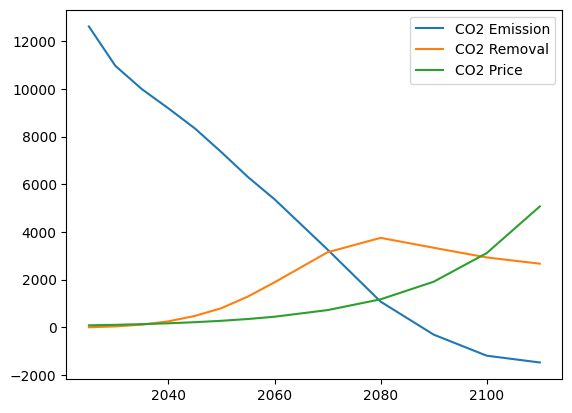

In [8]:
# CO2 Emission
emiss = scen.var("EMISS")
emiss = emiss.loc[(emiss['type_tec'] == 'all') & (emiss['node'] == 'World') & (emiss['emission'] == 'TCE')]
emiss_plot = emiss[['year','lvl']].set_index(['year'])

# CO2 Removal
removal = scen.var("EMISS")
removal = removal.loc[(removal['type_tec'] == 'all') & (removal['node'] == 'World') & (removal['emission'] == 'CO2_storage')]
removal_plot = removal[['year','lvl']].set_index(['year'])

# CO2 Prices
CO2Price = scen.var("PRICE_EMISSION")[['year','lvl']].set_index(['year'])

# Plottings
plt.plot(emiss_plot, label='CO2 Emission')
plt.plot(removal_plot, label='CO2 Removal')
plt.plot(CO2Price, label='CO2 Price')
plt.legend()
plt.show()

**compare with benchmark (base, cb1000):**

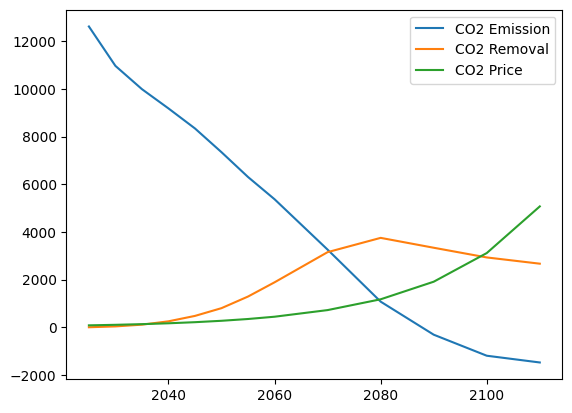

In [9]:
# CO2 Emission
emiss = base.var("EMISS")
emiss = emiss.loc[(emiss['type_tec'] == 'all') & (emiss['node'] == 'World') & (emiss['emission'] == 'TCE')]
emiss_plot = emiss[['year','lvl']].set_index(['year'])

# CO2 Removal
removal = base.var("EMISS")
removal = removal.loc[(removal['type_tec'] == 'all') & (removal['node'] == 'World') & (removal['emission'] == 'CO2_storage')]
removal_plot = removal[['year','lvl']].set_index(['year'])

# CO2 Prices
CO2Price = base.var("PRICE_EMISSION")[['year','lvl']].set_index(['year'])

# Plottings
plt.plot(emiss_plot, label='CO2 Emission')
plt.plot(removal_plot, label='CO2 Removal')
plt.plot(CO2Price, label='CO2 Price')
plt.legend()
plt.show()

## Add daccs to the scenario

In [10]:
# this is to import scenario from data base and clone to local
dac_scen = scen.clone(
    "GENIE_sandbox",
    "cb1000_splitCO2transdisp_dac",
    "split CO2 infrastructure with dac",
    keep_solution=False, 
)
dac_scen.check_out()

year_df = dac_scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = dac_scen.set("year")

In [11]:
# add daccs
filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/data/daccs_setup_data.yaml'
add_dac(dac_scen,filepath=filepath)

In [12]:
# removing some parameters
newpipesnstors = ['co2_tr_sd','co2_stor']
pars2remove = ['emission_factor','capacity_factor','var_cost','input','output']
for par in pars2remove:
    df = dac_scen.par(par,{'technology':newpipesnstors})
    df= df.loc[df['year_vtg'] != df['year_act']]
    dac_scen.remove_par(par, df)

# removing excess year_act
pars2remove = ['capacity_factor','fix_cost','input','output']
techs = ['dac_2', 'dac_1', 'dac_3', 'dac_4', 'dac_5']
for par in pars2remove:
    df = dac_scen.par(par,{'technology':techs})
    df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
    dac_scen.remove_par(par, df)

## Run the model and make report

In [13]:
dac_scen.commit(comment="emission bound with split CO2 infrastructure")
dac_scen.set_as_default()

dac_scen.solve(solve_options={'barcrossalg': '2','scaind':'0'}) # solve_options={'barcrossalg': '2','scaind':'1'}
dac_scen.var("OBJ")["lvl"]

2242408.5

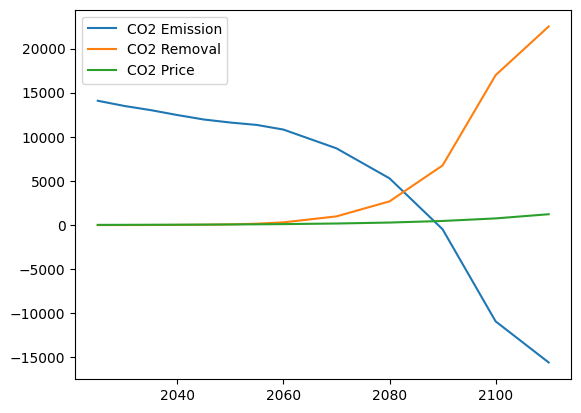

In [14]:
# CO2 Emission
emiss = dac_scen.var("EMISS")
emiss = emiss.loc[(emiss['type_tec'] == 'all') & (emiss['node'] == 'World') & (emiss['emission'] == 'TCE')]
emiss_plot = emiss[['year','lvl']].set_index(['year'])

# CO2 Removal
removal = dac_scen.var("EMISS")
removal = removal.loc[(removal['type_tec'] == 'all') & (removal['node'] == 'World') & (removal['emission'] == 'CO2_storage')]
removal_plot = removal[['year','lvl']].set_index(['year'])

# CO2 Prices
CO2Price = dac_scen.var("PRICE_EMISSION")[['year','lvl']].set_index(['year'])

# Plottings
plt.plot(emiss_plot, label='CO2 Emission')
plt.plot(removal_plot, label='CO2 Removal')
plt.plot(CO2Price, label='CO2 Price')
plt.legend()
plt.show()

**Get CO2 storage utilization for baseline**

In [15]:
nodes = [node for node in dac_scen.set("node") if node not in ["R11_GLB","World"]]

In [68]:
stored = (dac_scen.var("EMISS",{"emission":"CO2_storage",
                                "node":nodes,
                                "type_tec": "co2_potential"})
          .set_index(["node","year"])["lvl"]).unstack()
#stor100 = stored.groupby(level=0).sum()#.mul(10)
lenperiod = list(dac_scen.par("duration_period").set_index("year")[["value"]].reindex(stored.columns)["value"])
sco2capacity = stored.mul(lenperiod)
stor100 = list(sco2capacity.sum(axis=1).div(90))
stor100

[1133.0924941934127,
 624.5787763579697,
 70.14386239296466,
 194.76351929123985,
 640.7667161591717,
 515.8271669240023,
 986.601404306082,
 166.8619506378691,
 215.66373504690176,
 758.8963113091236,
 269.96186541369275]

## Varying storage potential

In [71]:
dac_scen_stor75 = dac_scen.clone(
    "GENIE_sandbox",
    "cb1000_splitCO2transdisp_dac_stor75",
    "split CO2 infrastructure with dac and 75% storage potential",
    keep_solution=False, 
)
dac_scen_stor75.check_out()

storpot = dac_scen_stor75.par('bound_emission',{"type_emission":"co2_storage_pot"})
newstorpot = storpot.copy()
newstorpot['value'] = [0.75*val for val in stor100]

# replace storage potentials with the new value
dac_scen_stor75.remove_par('bound_emission', storpot)
dac_scen_stor75.add_par('bound_emission', newstorpot)

# run scenarios
dac_scen_stor75.commit(comment="emission bound with split CO2 infrastructure")
dac_scen_stor75.set_as_default()
dac_scen_stor75.solve(solve_options={'barcrossalg': '2','scaind':'0'})
dac_scen_stor75.var("OBJ")["lvl"]

2254024.5

In [72]:
dac_scen_stor50 = dac_scen.clone(
    "GENIE_sandbox",
    "cb1000_splitCO2transdisp_dac_stor50",
    "split CO2 infrastructure with dac and 50% storage potential",
    keep_solution=False, 
)
dac_scen_stor50.check_out()

storpot = dac_scen_stor50.par('bound_emission',{"type_emission":"co2_storage_pot"})
newstorpot = storpot.copy()
newstorpot['value'] = [0.50*val for val in stor100]

# replace storage potentials with the new value
dac_scen_stor50.remove_par('bound_emission', storpot)
dac_scen_stor50.add_par('bound_emission', newstorpot)

# run scenarios
dac_scen_stor50.commit(comment="emission bound with split CO2 infrastructure")
dac_scen_stor50.set_as_default()
dac_scen_stor50.solve(solve_options={'barcrossalg': '2','scaind':'0'})
dac_scen_stor50.var("OBJ")["lvl"]

2332388.0

In [73]:
dac_scen_stor25 = dac_scen.clone(
    "GENIE_sandbox",
    "cb1000_splitCO2transdisp_dac_stor25",
    "split CO2 infrastructure with dac and 25% storage potential",
    keep_solution=False, 
)
dac_scen_stor25.check_out()

storpot = dac_scen_stor25.par('bound_emission',{"type_emission":"co2_storage_pot"})
newstorpot = storpot.copy()
newstorpot['value'] = [0.25*val for val in stor100]

# replace storage potentials with the new value
dac_scen_stor25.remove_par('bound_emission', storpot)
dac_scen_stor25.add_par('bound_emission', newstorpot)

# run scenarios
dac_scen_stor25.commit(comment="emission bound with split CO2 infrastructure")
dac_scen_stor25.set_as_default()
dac_scen_stor25.solve(solve_options={'barcrossalg': '2','scaind':'0'})
dac_scen_stor25.var("OBJ")["lvl"]

2513881.0

**Compile the reporting**

--------------------------------
Storage capacity: 100%
Total cost: 2242408.5


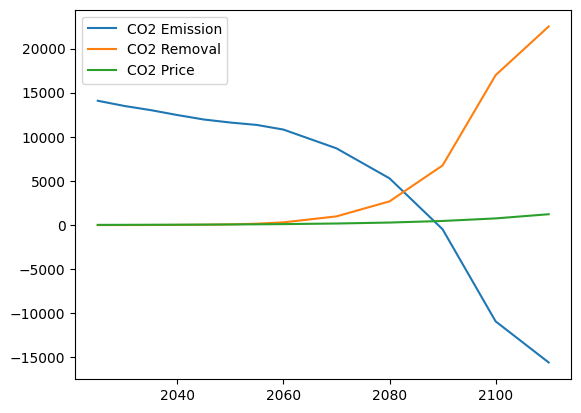

--------------------------------
Storage capacity: 75%
Total cost: 2254024.5


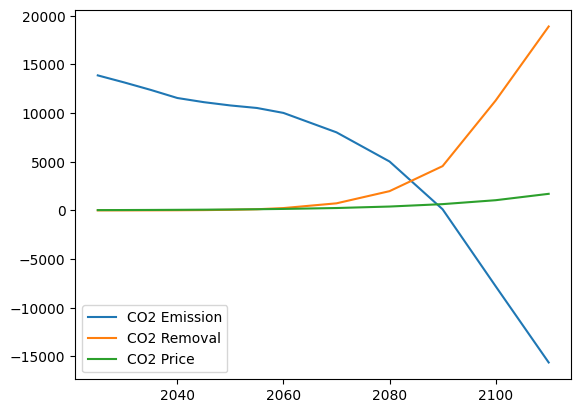

--------------------------------
Storage capacity: 50%
Total cost: 2332388.0


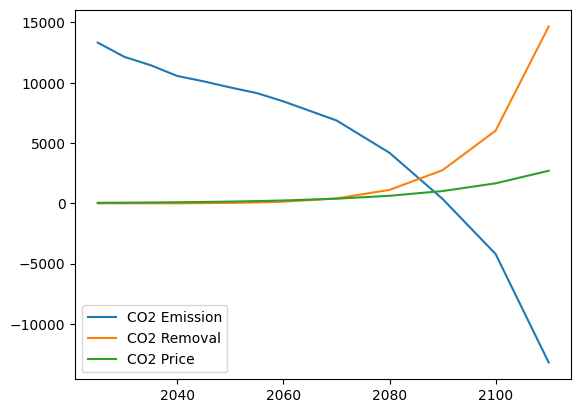

--------------------------------
Storage capacity: 25%
Total cost: 2513881.0


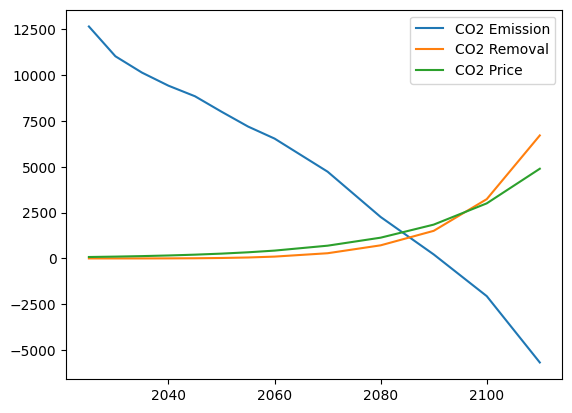

In [74]:
scenarios = {'100%':dac_scen, '75%':dac_scen_stor75, '50%':dac_scen_stor50, '25%':dac_scen_stor25}

for k,v in scenarios.items():
    print('--------------------------------')
    print('Storage capacity:',k)
    print('Total cost:',v.var("OBJ")["lvl"])
    # CO2 Emission
    emiss = v.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & (emiss['node'] == 'World') & (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year'])

    # CO2 Removal
    removal = v.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & (removal['node'] == 'World') & (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year'])

    # CO2 Prices
    CO2Price = v.var("PRICE_EMISSION").loc[v.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']].set_index(['year'])

    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    plt.legend()
    plt.show()

## Close connection

In [ ]:
mp.close_db()